In [1]:
from helpers.utilities import *
%run helpers/notebook_setup.ipynb

In [2]:
protein_levels_path = 'data/clean/protein/levels.csv'

# outputs
indexed_by_target_path = 'data/clean/protein/indexed_by_target.csv'
zz_log_path = 'data/clean/protein/zz_log_10.csv'
log_matrix_path = 'data/clean/protein/log_10.csv'
patients_variance_at_one_path = 'data/clean/protein/z_log_10-patients_variance_at_one.csv'

# Proteins: transformation & normalization

In [3]:
protein_levels = read_csv(protein_levels_path, index_col=[0, 1, 2, 3])

### Choosing a single, unique proteins index

As demonstrated in [Exploration_and_quality_control.ipynb](Exploration_and_quality_control.ipynb), `entrez_gene_symbol` unique. For simplicity - and to enable high interpretability - we will only use the `target` column to index proteins henceforth:

In [4]:
protein_levels = protein_levels.reset_index(level=[
    'target_full_name', 'entrez_gene_symbol', 'soma_id'
], drop=True)

In [5]:
protein_levels.head(2)

,149.TMD,007.TMD,001.TMD,064.TMD,151.TMD,...,177.HC,189.HC,217.HC,221.HC,245.HC
target,,,,,,,,,,,
CHIP,174.1,521.1,57.0,158.1,62.1,...,12.6,11.4,12.2,15.8,22.2
CEBPB,53.3,283.6,36.1,126.6,33.7,...,10.4,9.7,9.6,11.0,15.1


In [6]:
protein_levels.to_csv(indexed_by_target_path)

### What is the distribution of the measurments?

In [7]:
from statsmodels.graphics.gofplots import qqplot_2samples
from helpers.data_frame import select_columns

The quantile-quantile distribution between healthy controls and all the other samples:

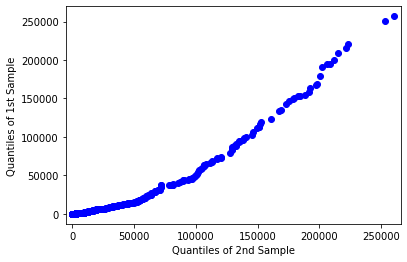

In [8]:
qqplot_2samples(
    select_columns(protein_levels, match='.*HC').mean(axis=1),
    select_columns(protein_levels, exclude='.*HC').mean(axis=1)
);

No striking outliers.

#### Are the average protein levels normally distributed?

In [9]:
average_protein_level = select_columns(protein_levels, '.*HC').mean(axis=1)

In [10]:
average_protein_level.head()

target
CHIP           15.104
CEBPB          12.424
NSE         10619.304
PIAS4          12.604
IL-10 Ra       76.396
dtype: float64

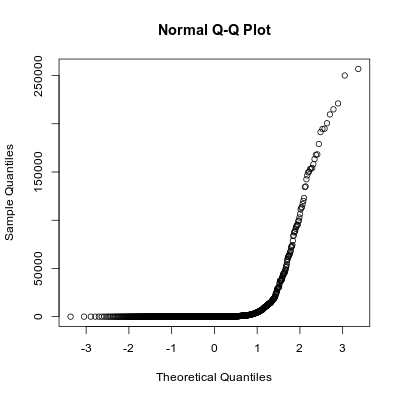

In [11]:
%%R -i average_protein_level -w 400 -h 400 -u px
qqnorm(average_protein_level)

Nope. This may be expected given the high dynamic range of the platform; it also tells us that there are many values close to zero:

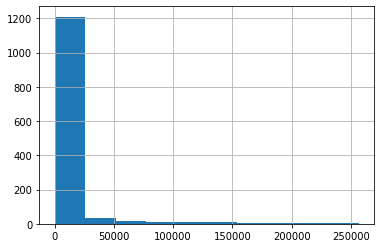

In [12]:
average_protein_level.hist();

### Does it follow log-normal distribution?

In [13]:
df = DataFrame(dict(average_protein_level=average_protein_level))

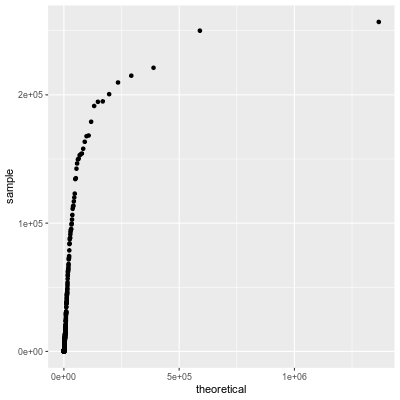

In [14]:
%%R -i df -w 400 -h 400 -u px
(
    ggplot(df, aes(sample=average_protein_level))
    + qqplotr::stat_qq_point(distribution='lnorm')
)

Not great, though better.

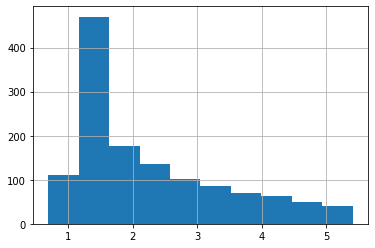

In [15]:
from numpy import log10
average_protein_level.apply(log10).hist();

#### Were there any useful notes in methods section of previous studies utilizing SOMAscan?

- "Protein levels were natural log transformed prior to batch effects adjustment to improve the normality of protein level distributions" - https://www.nature.com/articles/s41598-018-26640-w
- "All protein values were log transformed because of their nonnormal distributions as determined by the Kolomogorov-Smirnov and Shapiro-Wilk normality tests" - [Aptamer-Based Proteomic Profiling Reveals Novel Candidate Biomarkers and Pathways in Cardiovascular Disease
](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4963294/) (I don't quite get the reasoning of this sentence - non-normality does not imply log-normal distribution, regardless of the tests that you use)
- "all CSF and plasma protein values measured in untargeted and targeted proteomic experiments were log10 transformed" [The Alzheimer study](https://alzres.biomedcentral.com/articles/10.1186/s13195-017-0258-6)
- "Prior to analysis, NMR lipoprotein and plasma proteome data were transformed to Z-scores (by subtracting the mean and dividing by the SD) for ease of comparison. Plasma proteome data were log-transformed prior to Z-score transformation." [
(Harbaum, et al., 2019)](https://thorax.bmj.com/content/74/4/380) **this is a fresh study from Imperial College London**, and two of the authors are affiliated with the Department of Surgery and Cancer
- "Data from all samples were log2 transformed, normalized and calibrated using standard hybridization and calibration procedures." [(Scribe et al, 2017)](https://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1006687) - some authors affiliated with SomaLogic, NB this is also a Cape Town study.
- "All data were log-transformed to stabilize the variance. [...] Student's t tests were used to identify differentially expressed SOMAmer reagents" [(Groote, et al. 2017)](https://jcm.asm.org/content/55/2/391.long) - again in collaboration with SomaLogic.

There is a strong case for log-transformation, as it was frequently used in previous research. The base, however, varies.

I was specifically interested to see if anyone used Van der Waerden transformation before, as it could correct the skew (as partially does the log transformation). Here are two more articles:

- "All proteomics data were transformed using the natural logarithm and transformed to zero mean and unit s.d. In addition, protein values >2.5 s.d. from the mean were excluded as outliers." - this sounds like an exclusion of a lot of signal; in supplementary information: "This [modeling] was performed on the SOMAscan data, both untransformed, and transformed using the Van der Waerden transformation" -  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4490288/
- "We log10 transformed the protein data as the protein concentrations were not normally distributed. Additionally, protein values ± 6 SDs were excluded as outliers." - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4469006/ (same authors, previous article)


At least two studies first log-transformed and then scaled to z-scores.

Alternatives to simple log-transform include:
 - Box-Cox
 - quantile normalization / Van de Waerden / rank-based inverse normal transformation; possibly used in [this study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5271178/). There are articles discussing practical benefits and shortcomings of application to GWAS studies (I haven't found discussion relevant to SOMAscan though):
   - for [(Pain et al. 2018)](https://europepmc.org/articles/pmc6057994)
   - against [(Beasley et al. 2009)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2921808/) - I am convinced by some of the arguments, though can't say that I understand it fully (yet).

There seem to be a strong preference for the simplest log transformation in the previous research (though I do not fully understand this choice).

NB: the relative abundances of proteins in cells are known to vary greatly; our samples are not cells from a single tissue but a mixture of different cells and (potentially) organisms. This may influence the distribution of protein levels, and it appears justifiable to suspect that the measured distribution is complex and skewed as it is a sum of multiple distributions (which may or may not be normal). 

### Log-transformation with base 10

Since now, the log-10 transformed data will be used through the subsequent analyses. I chose base of 10 due to high range of the SOMAScan measurements.

In [16]:
from numpy import log10

In [17]:
log_matrix = protein_levels.applymap(log10)

In [18]:
log_matrix.to_csv(log_matrix_path)

### How to normalize the values for use with PLS?

Concern: the high dynamic range  of values 

z-score?

### Further attempts to normalize/transform

Some thoughts on transformations:
- we may suspect that there will be less proteins in the healthy controls,
    - we could control for that if the goal is to elucidate differences in the immune system proxies or look for specific biomarkers (i.e. what immune-response related proteins are more often active in the CSF when compared against the background)
    - but not controlling is a real-life scenario: the mere fact of detecting much more proteins than expected might be used to help diagnose the patient
- log transformation reduces the problem of high dynamic range. However, it also over-emphasizes the proteins with very low levels [(Berg et al, 2006)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1534033/) / common knowledge.
- z-score appears to be well suited for distributions closer to the normal family - as it uses mean and standard deviation
- it might be better to use the more robust median rather than mean as it is less prone to outliers [(Berg et al, 2006)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1534033/) / common knowledge. However, log-transformation partially alleviates this problem (and there is little precedent such approach)
- I would be tempted to use an advanced transformation followed by scaling, though there is little precedent in the field. Also, this would reduce the ease of interpretation of results (everyone understands log-transform, but not necessarily Box-Cox)

A [review of HCA for proteomic data](https://pubs.acs.org/doi/full/10.1021/pr060343h) mentions an alternative being division by maximum value of each sample - I would not do that as this procedure may susceptible to outliers, though they demonstrate that it gives better results than z-score (though not on SOMAscan data which has greater dynamic range).

#### Double z-score transformation for unsupervised analyses

I originally proposed to follow the log-transformation with:
 - z-score on samples (patients) - to address the issue of some samples having more proteins than others (which could be either technical or biological) - see 024.TMR (NB: the above discussed issue of the relative levels being potentially diagnostic is not necessarily important: confirming that more proteins in CSF may imply greater chance of a disease is not necessarily novel neither ambitious - I could just do a separate analysis for that); I could use modified z-score with median instead of mean (Iglewicz-Hoaglin) - though it does not seem to be necessary
 - z-score normalization of each feature (protein) - to give each protein an equal weight in the unsupervised analyses

Unfortunately, in this procedure the second step will reduce the impact of the first step. Thus the order matters and different results would be achieved depending on which normalization is performed first.

In [19]:
from helpers import z_score

In [20]:
zz_log_matrix = log_matrix.apply(z_score).apply(z_score, axis=1)

In [21]:
zz_log_matrix.to_csv(zz_log_path)

We have unit variance on proteins:

In [22]:
zz_log_matrix.var(axis=1)

target
CHIP        1.0
CEBPB       1.0
NSE         1.0
PIAS4       1.0
IL-10 Ra    1.0
           ... 
PEDF        1.0
CATF        1.0
FTCD        1.0
UBP25       1.0
PLXB2       1.0
Length: 1305, dtype: float64

#### Single-z score transformation to account for different protein abundances among patients

The above proposed transformations result in very good unsupervised clustering, however pose a challenge in the interpretation. Therefore I also use a simpler transformation with the single purpose of making the variance equal among all patients:

In [23]:
# Center patients and scale to unit variance
patients_variance_at_one = log_matrix.apply(z_score)

In [24]:
patients_variance_at_one.to_csv(patients_variance_at_one_path)

In [25]:
patients_variance_at_one.var()

149.TMD    1.0
007.TMD    1.0
001.TMD    1.0
064.TMD    1.0
151.TMD    1.0
          ... 
177.HC     1.0
189.HC     1.0
217.HC     1.0
221.HC     1.0
245.HC     1.0
Length: 82, dtype: float64

In [26]:
from numpy import isclose

assert all(map(partial(isclose, 1), patients_variance_at_one.var()))
assert all(map(partial(isclose, 0), patients_variance_at_one.mean()))

This transformation (depending on additional assumption on the intensity-variance relation) may help in comparison of protein abundances between the patients.